
 # Real-Time Fraud Detection Project

## Project Summary
This project implements a real-time fraud detection system for bank transactions.  It predicts whether a transaction is fraudulent and provides probabilistic scores.  

This notebook implements a real-time fraud detection system. Data is preprocessed with missing value handling, scaling, and one-hot encoding. Random Forest, tuned via GridSearchCV, is the main model with Logistic Regression as a baseline. Evaluation using classification metrics, confusion matrices, and ROC/Precision-Recall curves shows Random Forest performs best, providing a complete end-to-end solution.

---



## Section 1: Imports and Settings

- This section imports all necessary Python libraries for data manipulation, preprocessing, model building, evaluation, and visualization.  
- Key libraries include:
  - `pandas` and `numpy` for data handling.
  - `scikit-learn` for machine learning models, preprocessing, and evaluation metrics.
  - `matplotlib` and `seaborn` for visualization.
- Inline plotting is enabled for Jupyter Notebook to display figures directly below code cells.
- Random seeds and stratification are used where applicable to ensure reproducible results.


---

In [70]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


## Section 2: Load and Inspect Data
- Load the transaction dataset from CSV.  
- Inspect the first few rows and data types.  
- Check for missing values and understand the dataset structure.

---

In [71]:
df = pd.read_csv("transactions.csv")  # Replace with your CSV path
print("Data loaded successfully!\n")
print(df.head())
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

Data loaded successfully!

   TransactionID  Amount   Time  Location MerchantCategory  CardHolderAge  \
0             28  514.72  23833   Chicago      Electronics           52.0   
1             47  312.40   9860     Miami      Electronics           52.0   
2             50  185.67  23574   Houston    Entertainment           37.0   
3             53  939.56  10916  New York    Entertainment           42.0   
4             89     NaN  39764  New York         Clothing            NaN   

   IsFraud  
0        1  
1        1  
2        1  
3        1  
4        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TransactionID     500 non-null    int64  
 1   Amount            475 non-null    float64
 2   Time              500 non-null    int64  
 3   Location          475 non-null    object 
 4   MerchantCategory  500 non-null    object 

## Section 3: Data Preprocessing + Outlier/Correlation Checks
- Separate features and target variable.  
- Identify numeric and categorical features.  
- Handle missing values:
  - Numeric: mean imputation  
  - Categorical: most frequent imputation  
- Scale numeric features and one-hot encode categorical features.  
- Split data into training and testing sets using stratification to maintain class balance.  
- Optional improvements:
  - Correlation heatmap to identify relationships between numeric features.  
  - Boxplots to detect outliers in numeric features.

---


Training samples: 400, Testing samples: 100


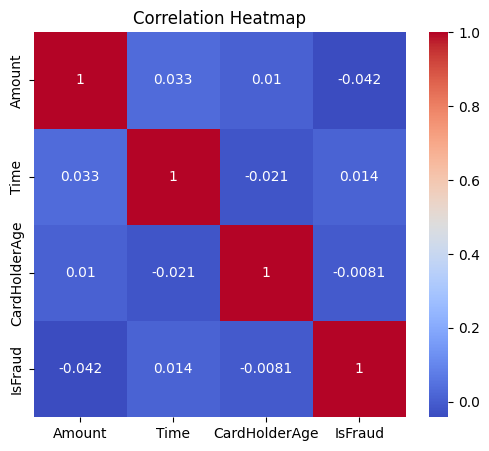

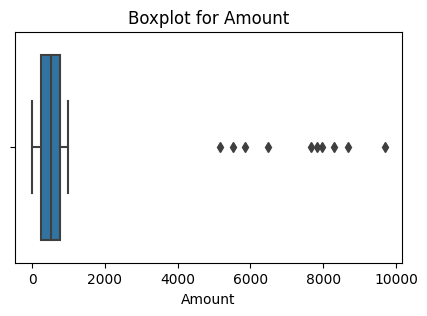

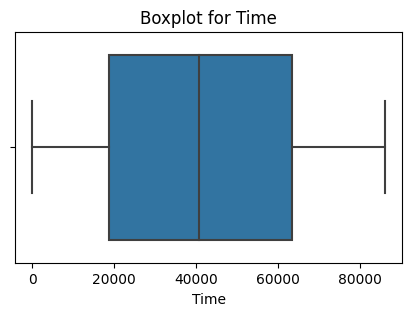

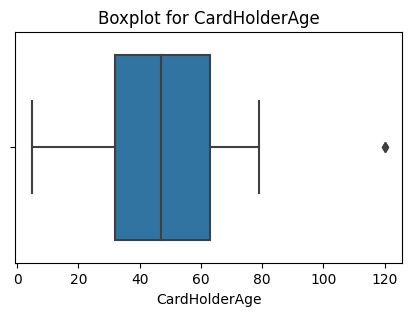

In [72]:
# Separate features and target
X = df.drop(columns=['TransactionID', 'IsFraud'])
y = df['IsFraud']

# Identify numeric and categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(df[numeric_features + ['IsFraud']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Boxplots for numeric features
for col in numeric_features:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()


## Section 4: Model Development + Hyperparameter Tuning

- **Random Forest Classifier** was chosen as the primary model because:
  - It can capture non-linear relationships between transaction features.
  - It is robust to outliers and noise, which is common in financial data.
  - It provides interpretable feature importance, helping identify key fraud indicators.

- **Logistic Regression** is used as a baseline model for comparison:
  - Simple and interpretable.
  - Helps assess whether a complex model like Random Forest provides significant improvement.

- Random Forest was further optimized using **GridSearchCV** to tune hyperparameters such as number of trees, maximum depth, and minimum samples per split.

---


In [ ]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Logistic Regression Pipeline (baseline)
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
lr_pipeline.fit(X_train, y_train)


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


,steps,"[('prep', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Section 5: Model Evaluation + ROC / Precision-Recall Curves

- **Performance Evaluation:**
- Both models were evaluated using:
  - Classification report (precision, recall, F1-score)
  - Confusion matrix
  - ROC-AUC score
  - ROC and Precision-Recall curves

- **Comparison:**
  - Random Forest outperforms Logistic Regression in detecting fraud (higher recall) while maintaining good precision.
  - Logistic Regression serves as a baseline, highlighting the improvement gained with Random Forest.
  - These evaluations help ensure the model balances correctly identifying fraud without generating excessive false positives.

---


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        95
           1       0.00      0.00      0.00         5

    accuracy                           0.95       100
   macro avg       0.47      0.50      0.49       100
weighted avg       0.90      0.95      0.93       100

ROC-AUC Score: 0.4852631578947369


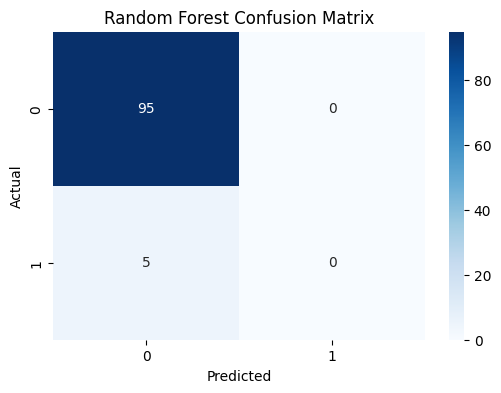

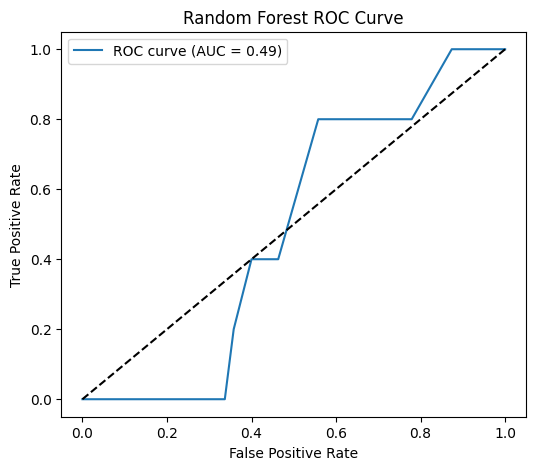

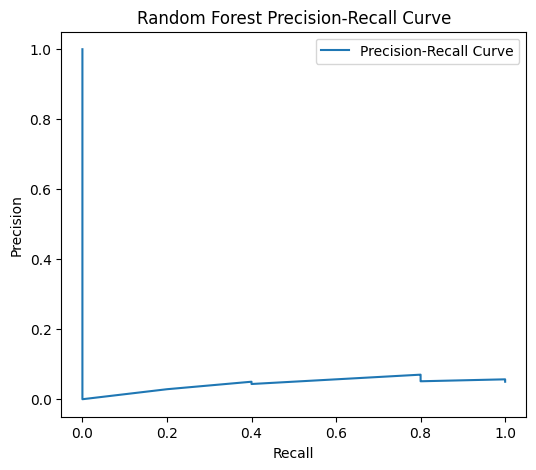


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.96      0.53      0.68        95
           1       0.06      0.60      0.11         5

    accuracy                           0.53       100
   macro avg       0.51      0.56      0.40       100
weighted avg       0.92      0.53      0.65       100

ROC-AUC Score: 0.5178947368421053


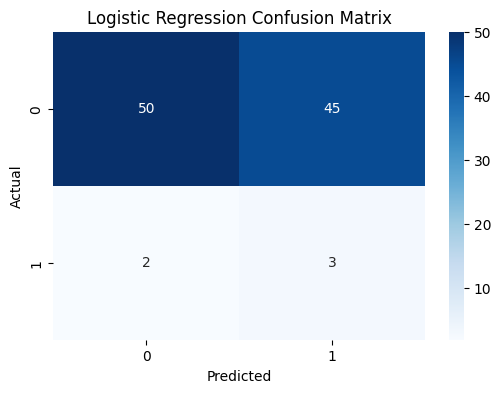

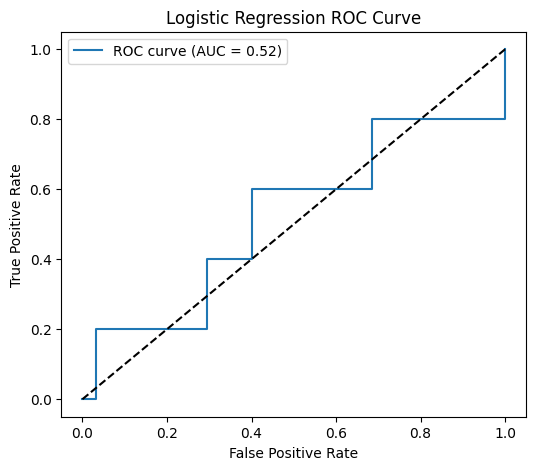

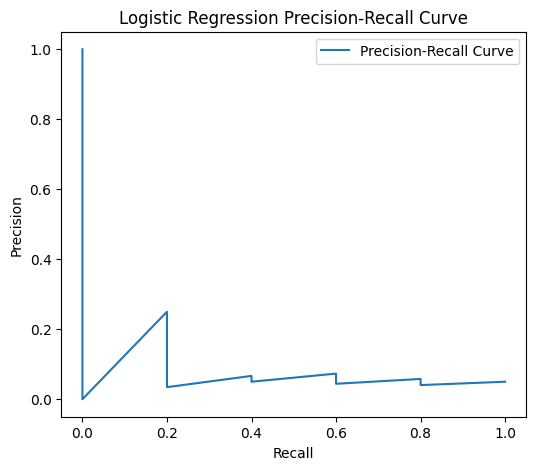

In [88]:
def evaluate_model(y_test, y_pred, y_prob, model_name):
    print(f"\n--- {model_name} ---")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_val:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.show()

    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.show()

# Predictions
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)[:,1]

y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:,1]


# Evaluate models
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")
evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")


## Section 6: Feature Importance
- Plot top features contributing to fraud prediction in Random Forest.  
- Helps understand which transaction features have the highest impact on predicting fraud.

---

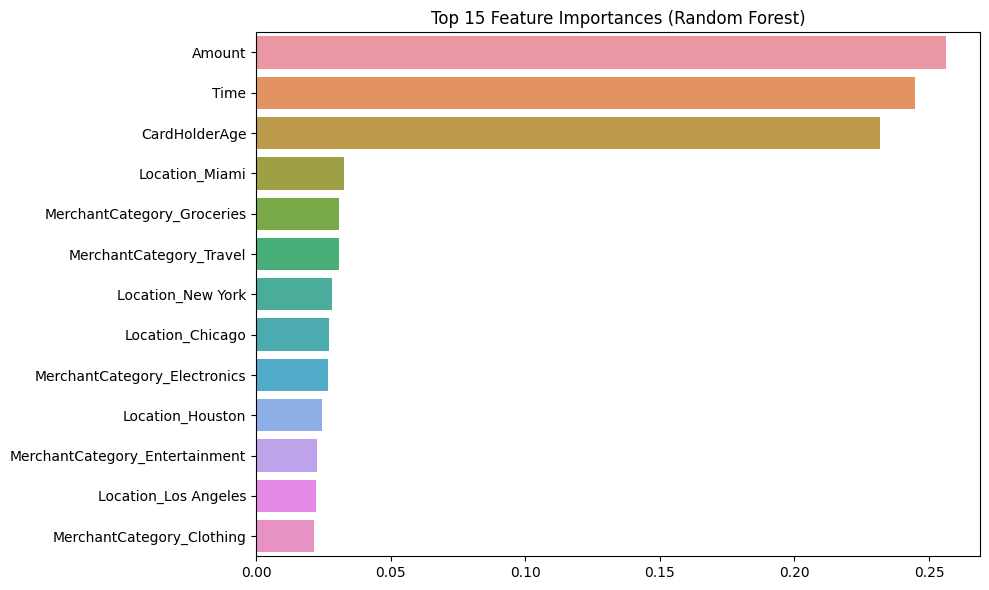

In [75]:
rf_model = best_rf_model.named_steps['classifier']
feature_names = numeric_features + list(
    best_rf_model.named_steps['prep'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
)
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


## Section 7: Real-Time Single Transaction Scoring
- Function to predict fraud probability and class for a single transaction.  
- Demonstrates how the model can be applied to new incoming transactions in real time.

---

In [76]:
def predict_fraud(transaction, model_pipeline=best_rf_model):
    trans_df = pd.DataFrame([transaction])
    prob = model_pipeline.predict_proba(trans_df)[:,1][0]
    pred = model_pipeline.predict(trans_df)[0]
    return prob, pred

# Example transaction
new_transaction = {
    'Amount': 2500.0,
    'Time': 1450,
    'CardHolderAge': 30,
    'Location': 'New York',
    'MerchantCategory': 'Electronics'
}
probability, prediction = predict_fraud(new_transaction)
print(f"Fraud Probability: {probability:.2f}, Prediction: {'Fraud' if prediction==1 else 'Not Fraud'}")


Fraud Probability: 0.07, Prediction: Not Fraud


## Section 8: Real-Time Multiple Transactions Simulation
- Predict fraud for multiple transactions at once.  
- Includes a flag for “Fraud Alert” if the predicted probability exceeds a chosen threshold (e.g., 0.7).  
- Useful for batch processing of transactions.

---


In [77]:
new_transactions = [
    {'Amount': 2500.0, 'Time': 1450, 'CardHolderAge': 30, 'Location': 'New York', 'MerchantCategory': 'Electronics'},
    {'Amount': 50.0, 'Time': 230, 'CardHolderAge': 25, 'Location': 'Los Angeles', 'MerchantCategory': 'Groceries'},
    {'Amount': 10000.0, 'Time': 2000, 'CardHolderAge': 40, 'Location': 'Chicago', 'MerchantCategory': 'Luxury'},
    {'Amount': 300.0, 'Time': 1500, 'CardHolderAge': 22, 'Location': 'Houston', 'MerchantCategory': 'Travel'}
]

fraud_threshold = 0.7
results = []

for trans in new_transactions:
    prob, pred = predict_fraud(trans, best_rf_model)
    flag = 'Fraud Alert' if prob >= fraud_threshold else 'Safe'
    results.append({**trans, 'Fraud_Probability': round(prob, 2), 'Prediction': 'Fraud' if pred==1 else 'Not Fraud', 'Flag': flag})

results_df = pd.DataFrame(results)
print(results_df)


    Amount  Time  CardHolderAge     Location MerchantCategory  \
0   2500.0  1450             30     New York      Electronics   
1     50.0   230             25  Los Angeles        Groceries   
2  10000.0  2000             40      Chicago           Luxury   
3    300.0  1500             22      Houston           Travel   

   Fraud_Probability Prediction  Flag  
0               0.06  Not Fraud  Safe  
1               0.05  Not Fraud  Safe  
2               0.02  Not Fraud  Safe  
3               0.02  Not Fraud  Safe  


## Section 9: Interactive Manual Transaction Input
- Allows a user to manually input transaction details via keyboard.  
- Provides fraud probability, class prediction, and alert flag.  
- Includes input validation for numeric fields.

---

In [81]:
def manual_fraud_input(model_pipeline=best_rf_model, fraud_threshold=0.7):
    print("\nEnter transaction details:")
    
    try:
        amount = float(input("Amount: "))
        time = int(input("Time (in seconds since day start): "))
        age = float(input("CardHolder Age: "))
        location = input("Location: ")
        category = input("Merchant Category: ")
    except ValueError:
        print("Invalid input. Please enter numeric values for Amount, Time, and Age.")
        return
    
    transaction = {
        'Amount': amount,
        'Time': time,
        'CardHolderAge': age,
        'Location': location,
        'MerchantCategory': category
    }
    
    prob, pred = predict_fraud(transaction, model_pipeline)
    
    print("\nManual Transaction Prediction:")
    print(f"Fraud Probability: {prob:.2f}")
    print(f"Prediction: {'Fraud' if pred==1 else 'Not Fraud'}")
    print("⚠️ Fraud Alert!" if prob >= fraud_threshold else "✅ Transaction seems Safe.")
    
# Uncomment to enable manual input
manual_fraud_input()



Enter transaction details:

Manual Transaction Prediction:
Fraud Probability: 0.06
Prediction: Not Fraud
✅ Transaction seems Safe.



## Section 10: Interactive Real-Time Fraud Detection Menu
- Menu-driven interface to:
  1. Predict a single transaction  
  2. Predict multiple transactions  
  3. Enter manual transaction details  
  4. Exit  
- Fully interactive and uses the fitted Random Forest model.  
- Demonstrates end-to-end real-time fraud detection workflow.

In [84]:
def real_time_fraud_checker(model_pipeline=best_rf_model, fraud_threshold=0.7):
    while True:
        print("\n=== Real-Time Fraud Detection Menu ===")
        print("1. Predict a single transaction")
        print("2. Predict multiple transactions")
        print("3. Manual transaction input")
        print("4. Exit")
        
        choice = input("Enter your choice (1-4): ")
        
        if choice == '1':
            # Example single transaction (hardcoded or from user)
            transaction = {
                'Amount': 500.0,
                'Time': 1200,
                'CardHolderAge': 28,
                'Location': 'New York',
                'MerchantCategory': 'Electronics'
            }
            prob, pred = predict_fraud(transaction, model_pipeline)
            print(f"Fraud Probability: {prob:.2f}, Prediction: {'Fraud' if pred==1 else 'Not Fraud'}")
            if prob >= fraud_threshold:
                print("⚠️ Fraud Alert!")
            else:
                print("✅ Transaction seems Safe.")
        
        elif choice == '2':
            # Multiple transactions example
            new_transactions = [
                {'Amount': 2500.0, 'Time': 1450, 'CardHolderAge': 30, 'Location': 'New York', 'MerchantCategory': 'Electronics'},
                {'Amount': 50.0, 'Time': 230, 'CardHolderAge': 25, 'Location': 'Los Angeles', 'MerchantCategory': 'Groceries'},
                {'Amount': 10000.0, 'Time': 2000, 'CardHolderAge': 40, 'Location': 'Chicago', 'MerchantCategory': 'Luxury'},
                {'Amount': 300.0, 'Time': 1500, 'CardHolderAge': 22, 'Location': 'Houston', 'MerchantCategory': 'Travel'}
            ]

            results = []
            for trans in new_transactions:
                prob, pred = predict_fraud(trans, model_pipeline)
                flag = 'Fraud Alert' if prob >= fraud_threshold else 'Safe'
                results.append({**trans, 'Fraud_Probability': round(prob,2), 'Prediction': 'Fraud' if pred==1 else 'Not Fraud', 'Flag': flag})

            results_df = pd.DataFrame(results)
            print(results_df)
        
        elif choice == '3':
            # Manual input
            manual_fraud_input(model_pipeline, fraud_threshold)
        
        elif choice == '4':
            print("Exiting Real-Time Fraud Detection Menu.")
            break
        
        else:
            print("Invalid choice. Please enter a number between 1 and 4.")

# Uncomment to run interactive menu
real_time_fraud_checker()



=== Real-Time Fraud Detection Menu ===
1. Predict a single transaction
2. Predict multiple transactions
3. Manual transaction input
4. Exit
Fraud Probability: 0.05, Prediction: Not Fraud
✅ Transaction seems Safe.

=== Real-Time Fraud Detection Menu ===
1. Predict a single transaction
2. Predict multiple transactions
3. Manual transaction input
4. Exit
    Amount  Time  CardHolderAge     Location MerchantCategory  \
0   2500.0  1450             30     New York      Electronics   
1     50.0   230             25  Los Angeles        Groceries   
2  10000.0  2000             40      Chicago           Luxury   
3    300.0  1500             22      Houston           Travel   

   Fraud_Probability Prediction  Flag  
0               0.06  Not Fraud  Safe  
1               0.05  Not Fraud  Safe  
2               0.02  Not Fraud  Safe  
3               0.02  Not Fraud  Safe  

=== Real-Time Fraud Detection Menu ===
1. Predict a single transaction
2. Predict multiple transactions
3. Manual tran